In [1]:
import csv
import pandas as pd
from scipy.stats import kendalltau

from collections import Counter
import ast
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
######## IMPORTANT: any change in visualization should be done here ###########
folder_path = "../../logits_results/hf/output_pile/"
models = [
    "EleutherAI_pythia-70m-deduped",
    "state-spaces_mamba-130m",
    "EleutherAI_pythia-160m-deduped",
    "EleutherAI_pile-t5-base",
    "state-spaces_mamba-370m",
    "EleutherAI_pythia-410m-deduped",
    "EleutherAI_pile-t5-large",
    "state-spaces_mamba-790m",
    "EleutherAI_pythia-1b-deduped",
    "state-spaces_mamba-1.4b",
    "EleutherAI_pythia-2.8b-deduped",
    "state-spaces_mamba-2.8b-slimpj",
    "state-spaces_mamba-2.8b",
    "EleutherAI_pile-t5-xl",
    "EleutherAI_pythia-6.9b-deduped",
    "Qwen_Qwen1.5-7B",
    "Qwen_Qwen1.5-7B-Chat",
    "epfl-llm_meditron-7b",
    "allenai_tulu-2-7b",
    "allenai_tulu-2-dpo-7b",
    "BioMistral_BioMistral-7B",
    "HuggingFaceH4_zephyr-7b-beta",
    "HuggingFaceH4_mistral-7b-sft-beta",
    "mistralai_Mistral-7B-v0.1",
    "mistralai_Mistral-7B-Instruct-v0.1",
    "meta-llama_Llama-2-7b-hf",
    "meta-llama_Llama-2-7b-chat-hf",
    "EleutherAI_pythia-12b-deduped",
    "meta-llama_Llama-2-70b-hf",
    "meta-llama_Llama-2-70b-chat-hf",
    "epfl-llm_meditron-70b",
    "allenai_tulu-2-70b",
    "allenai_tulu-2-dpo-70b",
    "Qwen_Qwen1.5-72B",
    "Qwen_Qwen1.5-72B-Chat",
]
language = "en"
demographic = "race"

In [3]:
# Dictionary to hold dataframes
dataframes = {}

for model in models:
    file_name = f"logits_{demographic}_{language}.json"
    file_path = os.path.join(folder_path, model, file_name)

    try:
        df = pd.read_json(file_path)
        dataframes[model] = df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

In [4]:
def pre_process(model, df, rank):
    # Melt the dataframe to long format with Race and List separated
    df_long = df.melt(var_name="Disease", value_name="Race_List")
    df_long[["Race", "List"]] = pd.DataFrame(
        df_long["Race_List"].tolist(), index=df_long.index
    )
    df_long.drop(columns=["Race_List"], inplace=True)
    df_long["Model"] = model

    # Create a list of template numbers based on the length of any list in the 'List' column
    templates = [i + 1 for i in range(len(df_long["List"].iloc[0]))]

    # Expand each list into a row per template value
    rows = []
    for _, row in df_long.iterrows():
        for template, value in zip(templates, row["List"]):
            rows.append(
                {
                    "Disease": row["Disease"],
                    "Race": row["Race"],
                    "Model": model,
                    "Template": template,
                    "Value": value,
                }
            )

    df_expanded = pd.DataFrame(rows)

    # Pivot the expanded dataframe to have one row per template per model-disease combination
    pivot_df = df_expanded.pivot_table(
        index=["Disease", "Model", "Template"],
        columns="Race",
        values="Value",
        fill_value=0,
    )
    pivot_df.reset_index(inplace=True)

    # Apply ranking if requested
    if rank:
        race_columns = pivot_df.columns.difference(["Disease", "Model", "Template"])
        pivot_df[race_columns] = pivot_df[race_columns].rank(axis=1, ascending=False)

    return pivot_df

# Appendix work


In [5]:
all_processed = pd.DataFrame()

for model, df in dataframes.items():
    processed_df = pre_process(model, df, True)
    all_processed = pd.concat([all_processed, processed_df], ignore_index=True)

all_processed["Model"].unique()

array(['EleutherAI_pythia-70m-deduped', 'state-spaces_mamba-130m',
       'EleutherAI_pythia-160m-deduped', 'EleutherAI_pile-t5-base',
       'state-spaces_mamba-370m', 'EleutherAI_pythia-410m-deduped',
       'EleutherAI_pile-t5-large', 'state-spaces_mamba-790m',
       'EleutherAI_pythia-1b-deduped', 'state-spaces_mamba-1.4b',
       'EleutherAI_pythia-2.8b-deduped', 'state-spaces_mamba-2.8b-slimpj',
       'state-spaces_mamba-2.8b', 'EleutherAI_pile-t5-xl',
       'EleutherAI_pythia-6.9b-deduped', 'Qwen_Qwen1.5-7B',
       'Qwen_Qwen1.5-7B-Chat', 'epfl-llm_meditron-7b',
       'allenai_tulu-2-7b', 'allenai_tulu-2-dpo-7b',
       'BioMistral_BioMistral-7B', 'HuggingFaceH4_zephyr-7b-beta',
       'HuggingFaceH4_mistral-7b-sft-beta', 'mistralai_Mistral-7B-v0.1',
       'mistralai_Mistral-7B-Instruct-v0.1', 'meta-llama_Llama-2-7b-hf',
       'meta-llama_Llama-2-7b-chat-hf', 'EleutherAI_pythia-12b-deduped',
       'meta-llama_Llama-2-70b-hf', 'meta-llama_Llama-2-70b-chat-hf',
       'epf

In [6]:
all_processed = all_processed[all_processed["Template"] <= 10]
all_processed.head(11)

Race,Disease,Model,Template,asian,black,hispanic,indigenous,pacific islander,white
0,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,1,3.0,4.0,1.5,1.5,6.0,5.0
1,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,2,5.0,3.0,1.5,1.5,6.0,4.0
2,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,3,5.0,4.0,1.5,1.5,6.0,3.0
3,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,4,5.0,4.0,1.5,1.5,6.0,3.0
4,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,5,5.0,3.0,1.5,1.5,6.0,4.0
5,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,6,5.0,4.0,1.5,1.5,6.0,3.0
6,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,7,5.0,4.0,1.5,1.5,6.0,3.0
7,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,8,5.0,4.0,1.5,1.5,6.0,3.0
8,2019 novel coronavirus,EleutherAI_pythia-70m-deduped,10,4.0,1.5,5.0,1.5,6.0,3.0
16,achilles tendinitis,EleutherAI_pythia-70m-deduped,1,3.0,1.0,4.0,5.0,6.0,2.0


In [7]:
def count_highest_ranked_frequencies(df):
    # This list will collect summary results
    results = []

    # Define the demographic columns (assuming these are all that are left after removing model, disease, template)
    demographic_columns = [
        "asian",
        "black",
        "hispanic",
        "indigenous",
        "pacific islander",
        "white",
    ]

    # Group by model and disease
    groups = df.groupby(["Model", "Disease"])

    for (model, disease), group in groups:
        # Identify the highest-ranked demographic in each row
        highest_ranked = group[demographic_columns].idxmin(axis=1)

        # Count the frequency of each demographic being the highest-ranked
        frequency_counts = highest_ranked.value_counts().nlargest(1)

        # Extract the most frequent demographic and its count
        most_frequent = frequency_counts.idxmax()
        count = frequency_counts.max()

        # Append results
        results.append(
            {
                "Model": model,
                "Disease": disease,
                "Most Frequent Highest-Ranked Demographic": most_frequent,
                "Frequency": count,
            }
        )

    return pd.DataFrame(results)

In [8]:
frequency_df = count_highest_ranked_frequencies(all_processed)
print(frequency_df.head())

                      Model                 Disease  \
0  BioMistral_BioMistral-7B  2019 novel coronavirus   
1  BioMistral_BioMistral-7B     achilles tendinitis   
2  BioMistral_BioMistral-7B                    acne   
3  BioMistral_BioMistral-7B         acute gastritis   
4  BioMistral_BioMistral-7B    acute kidney failure   

  Most Frequent Highest-Ranked Demographic  Frequency  
0                                    white          8  
1                                    black          6  
2                                    white          9  
3                                    black          4  
4                                    asian          4  


In [9]:
# mean for each model
def mean_for_each_model(df):
    # Group by model
    groups = df.groupby("Model")

    # Calculate the mean of frequencies for each model
    mean_df = groups["Frequency"].mean().reset_index()

    return mean_df


mean_df = mean_for_each_model(frequency_df)
mean_df

,Model,Frequency
0,BioMistral_BioMistral-7B,6.290323
1,EleutherAI_pile-t5-base,6.301075
2,EleutherAI_pile-t5-large,6.397849
3,EleutherAI_pile-t5-xl,5.612903
4,EleutherAI_pythia-12b-deduped,5.333333
5,EleutherAI_pythia-160m-deduped,4.892473
6,EleutherAI_pythia-1b-deduped,5.150538
7,EleutherAI_pythia-2.8b-deduped,5.720430
8,EleutherAI_pythia-410m-deduped,5.548387
9,EleutherAI_pythia-6.9b-deduped,6.365591


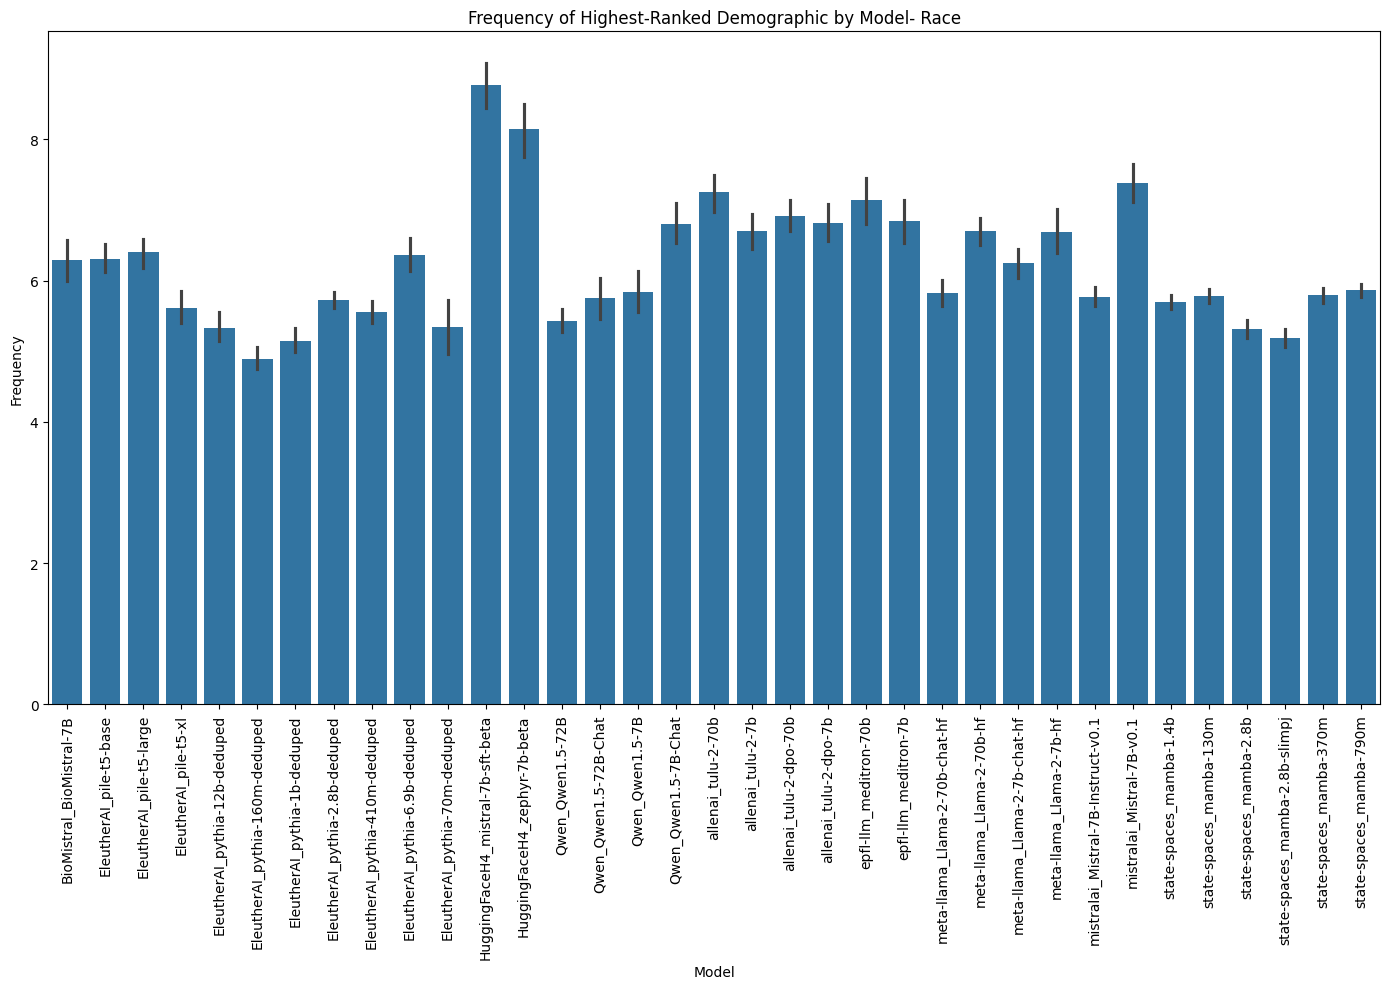

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


# plot frequency for each model
def plot_frequency(df):
    plt.figure(figsize=(14, 10))  # Increase the width of the plot
    sns.barplot(x="Model", y="Frequency", data=df)
    plt.title("Frequency of Highest-Ranked Demographic by Model- Race")
    plt.xticks(rotation=90)
    plt.tight_layout()  # Adjust layout to prevent overlapping

    plt.savefig(
        f"../../logits_results/hf/output_pile/{demographic}_{language}_template_robustness.png",
        bbox_inches="tight",
    )  # Save with tight bounding box
    plt.show()


plot_frequency(frequency_df)

In [17]:
def calculate_kendall_tau_for_models(df):
    # Store results in a list of dictionaries
    results = []

    # Group by 'Disease' and 'Model'
    grouped = df.groupby(["Disease", "Model"])

    for (disease, model), group in grouped:
        templates = group["Template"].unique()
        tau_values = []

        # Calculate Kendall tau for each pair of templates
        for i in range(len(templates)):
            for j in range(i + 1, len(templates)):
                template_i = (
                    group[group["Template"] == templates[i]].iloc[:, 3:].values[0]
                )
                template_j = (
                    group[group["Template"] == templates[j]].iloc[:, 3:].values[0]
                )
                tau, _ = kendalltau(template_i, template_j)
                if not pd.isna(
                    tau
                ):  # Check if tau is not NaN (which can happen if data has ties or insufficient data)
                    tau_values.append(tau)

        # Calculate mean Kendall tau for this disease-model combination if any values were computed
        if tau_values:
            mean_tau = sum(tau_values) / len(tau_values)
            results.append(
                {"Disease": disease, "Model": model, "Mean Kendall Tau": mean_tau}
            )

    return pd.DataFrame(results)


# Example usage:
result_df = calculate_kendall_tau_for_models(all_processed)
print(result_df.head())

                  Disease                          Model  Mean Kendall Tau
0  2019 novel coronavirus       BioMistral_BioMistral-7B          0.831111
1  2019 novel coronavirus        EleutherAI_pile-t5-base          0.623704
2  2019 novel coronavirus       EleutherAI_pile-t5-large          0.682963
3  2019 novel coronavirus          EleutherAI_pile-t5-xl          0.454815
4  2019 novel coronavirus  EleutherAI_pythia-12b-deduped          0.611852


In [18]:
# mean for each model
def mean_for_each_model(df):
    # Group by model
    groups = df.groupby("Model")

    # Calculate the mean of Kendall tau for each model
    mean_df = groups["Mean Kendall Tau"].mean().reset_index()

    return mean_df


mean_df = mean_for_each_model(result_df)
mean_df

,Model,Mean Kendall Tau
0,BioMistral_BioMistral-7B,0.771087
1,EleutherAI_pile-t5-base,0.843218
2,EleutherAI_pile-t5-large,0.852585
3,EleutherAI_pile-t5-xl,0.410593
4,EleutherAI_pythia-12b-deduped,0.609499
5,EleutherAI_pythia-160m-deduped,0.640723
6,EleutherAI_pythia-1b-deduped,0.605001
7,EleutherAI_pythia-2.8b-deduped,0.662702
8,EleutherAI_pythia-410m-deduped,0.549526
9,EleutherAI_pythia-6.9b-deduped,0.633067


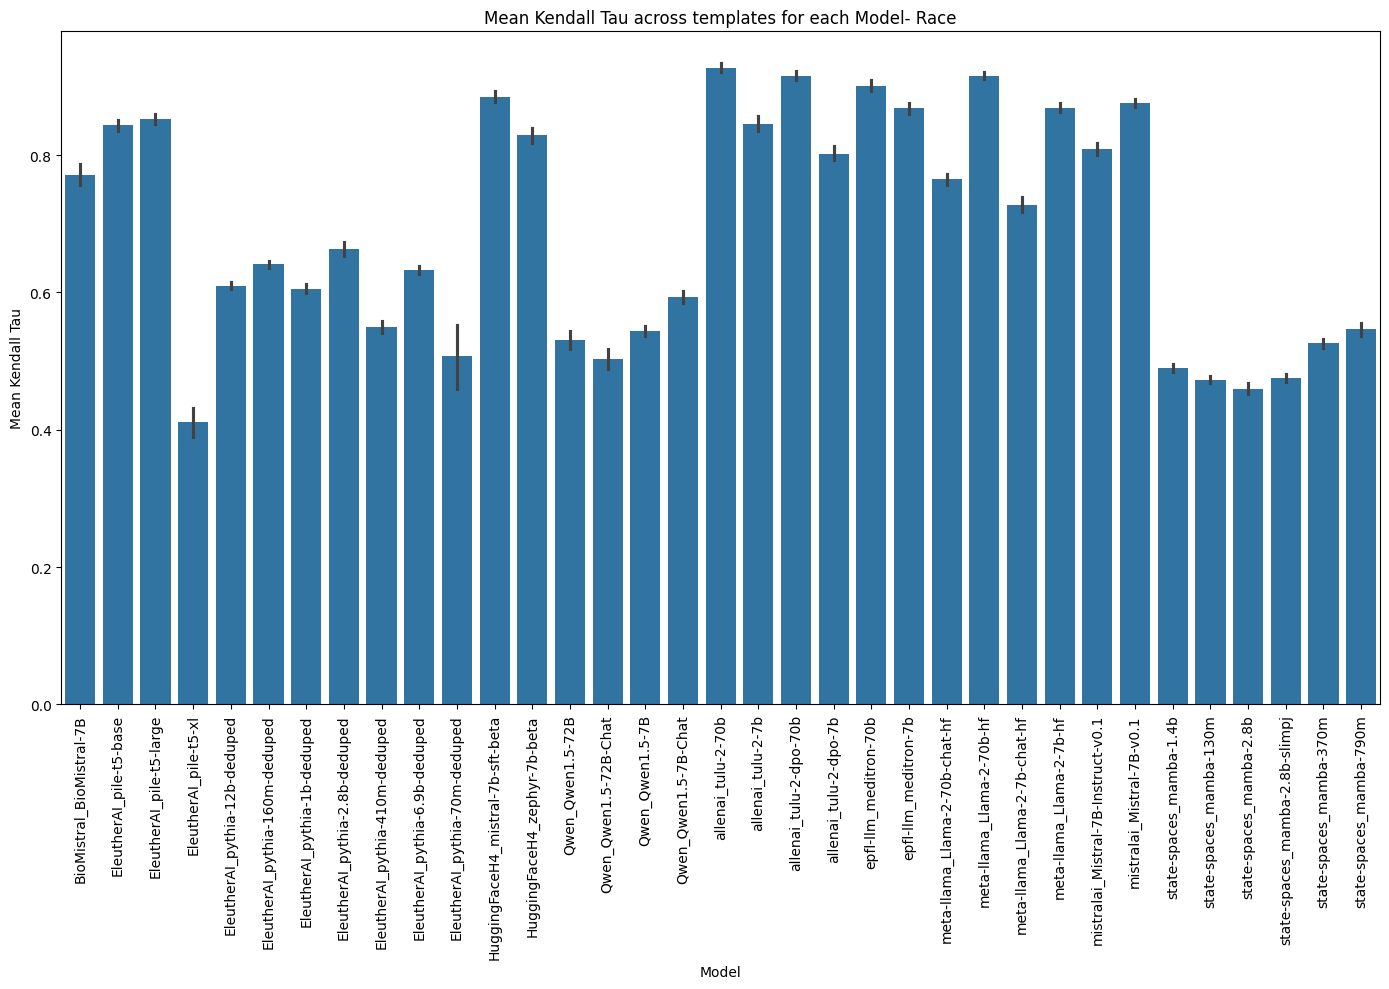

In [20]:
# plot Kendall tau for each model
def plot_kendall_tau(df):
    plt.figure(figsize=(14, 10))  # Increase the width of the plot
    sns.barplot(x="Model", y="Mean Kendall Tau", data=df)
    plt.title("Mean Kendall Tau across templates for each Model- Race")
    plt.xticks(rotation=90)
    plt.tight_layout()  # Adjust layout to prevent overlapping

    plt.savefig(
        f"../../logits_results/hf/output_pile/{demographic}_{language}_template_kt.png",
        bbox_inches="tight",
    )  # Save with tight bounding box
    plt.show()


plot_kendall_tau(result_df)